# 分析结构化数据

## 本章内容包括
- 将问题转换为查询
- 构建自然语言接口
- 分析数据表
- 分析图数据

世界上很大一部分信息以结构化数据的形式存储。结构化数据指的是以标准化格式存储的数据。例如，数据表（例如Excel电子表格中的数据）和描述实体及其关系的图（如描述社交网络的数据集）是结构化数据的常见类型。

处理结构化数据的工具已经存在了很多年。由于结构化数据采用标准化格式，便于计算机处理。那么为什么我们还需要大型语言模型呢？问题在于现有处理结构化数据工具的界面。通常，每种工具（或者至少是每类特定类型结构化数据工具）都有自己正式的查询语言。

本章节介绍如何创建多种自然语言查询接口。自然语言查询接口用于回答基于自然语言的问题，涉及不同类型的结构化数据。

首先，介绍针对表格数据的自然语言接口，然后介绍针对图数据的接口。核心原则是数据通过特定的数据处理工具处理，例如：

- 表格数据使用关系型数据库管理系统（RDBMS），其查询语言通常是SQL。
- 图数据使用图数据库管理系统，支持多种查询语言，如Cypher语言，专门用于描述图数据的分析操作。

自然语言接口通过大语言模型将自然语言问题翻译为具体的查询语言（如SQL或Cypher），需要了解目标语言及数据结构的信息（如表名、列名、数据类型等），从而准确生成形式化查询。

生成的查询可由专门工具执行，得到查询结果。图5.1展示了该处理流程。

---

## 为什么需要外部工具？

虽然大语言模型能力强大，但直接用它们分析结构化数据在效率上不划算，特别是大数据集超过模型输入限制时。依赖专门工具处理大规模数据更为合理。

## 5.2 用自然语言查询界面分析游戏销售数据

你老板是一位电脑游戏爱好者，喜欢玩游戏和分析游戏数据。最近他获得了一份电脑游戏销售数据，想从中提取有趣的统计信息。虽然SQL是分析表格数据的首选语言，但老板不太熟悉写SQL查询。于是，你的任务是帮忙构建一个接口，将自然语言查询转换成对应的SQL查询。

### 5.2.1 建立一个SQLite数据库

在用SQL分析表格数据前，需先将数据加载到关系型数据库(SQLite)中。

1. 确认电脑已安装SQLite(版本3)，命令行输入：
   ```bash
   sqlite3 --version
   ```
   正常会看到类似于 `3.33.0 2020-08-14 13:23:32 fca8...` 的版本信息。

2. 创建一个新的数据库文件 `games.db` 并进入SQLite命令行界面：
   ```bash
   sqlite3 games.db
   ```

3. 在SQLite中定义一个表结构，示例如下：
   ```sql
   CREATE TABLE games(
     rank int,
     name text,
     platform text,
     year int,
     genre text,
     publisher text,
     americasales numeric,
     eusales numeric,
     japansales numeric,
     othersales numeric,
     globalsales numeric
   );
   ```
   表 `games` 用来存储游戏信息，共定义了多列，包含游戏名、平台、年份、类型、发行商及多地区销售额等。

4. 导入CSV格式的数据文件(假设存放在 `/Downloads/videogames.csv`):
   ```sql
   .mode csv
   .import /Downloads/videogames.csv games
   ```

5. 通过运行下列SQL语句检验数据是否导入成功：
   ```sql
   SELECT count(*) FROM games;
   ```
   如果数据显示 `16599`，说明数据已完整加载。

最后，使用 `.quit` 命令退出SQLite命令行界面。

---

书中表5.1样例展示了部分数据，每行代表一款游戏，包含名称(Name)、平台(Platform)、年份(Year)和类型(Genre)四列信息。

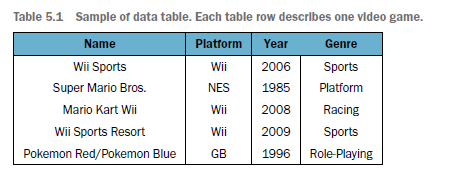

## SQL 基础知识总结

### 1. SQL 查询基本结构
- SQL 查询主要用于分析数据表，查询结果可以来自单表或多表组合。
- 数据库示例中只有一个表（games），SQL 查询一般具有以下结构：
  - `SELECT` 子句：指定要查询的列或聚合结果。
  - `FROM` 子句：指定数据来源的表名。
  - `WHERE` 子句：指定查询条件，过滤满足条件的行。

### 2. 子句说明
- `FROM` 子句：描述数据来源，可以包含一个或多个表名（用逗号分隔）。
- `WHERE` 子句：定义筛选条件，可使用等式、不等式等简单条件，也可用 AND、OR 连接多个条件。

### 3. SELECT 子句详解
- 指定结果表中的列，列可以是表中的列名，也可以是表达式或聚合函数（如`count(*)`）。
- 查询结果是包含指定列内容的表。

### 4. 示例查询
- 查询2017年所有游戏的总数：
  ```sql
  SELECT Count(*)
  FROM games
  WHERE year = 2017
  ```

- 查询2017年指定发行商（Activision）在欧洲和日本的销售总和和游戏名称：
  ```sql
  SELECT name, eusales + japansales
  FROM games
  WHERE year = 2017 AND publisher = 'Activision'
  ```

- 按游戏类型（genre）分组，统计每种类型的销售总和：
  ```sql
  SELECT genre, name, eusales + japansales
  FROM games
  WHERE year = 2017 AND publisher = 'Activision'
  GROUP BY genre
  ```

# Text-to-SQL 翻译简要说明及代码示例

## 5.2.3 概述
本节介绍了利用语言模型将自然语言问题翻译成SQL查询的过程。通过命令行输入一个问题，期望语言模型输出对应的SQL查询语句。在SQLite中执行该查询应返回原始问题的答案。目前界面是手动操作，目标是实现自动执行查询并直接显示结果。阶段性目标是将关于电脑游戏的问题翻译成SQL查询，数据库结构暂时硬编码。

翻译流程中，首先构造一个提示（prompt），描述翻译任务及目标数据库结构。将该提示发送给语言模型后，返回相应的SQL查询。可能需要额外处理，提取出语言模型输出中的SQL语句。

## 5.2.4 生成Text-to-SQL翻译提示（prompt）
要顺利翻译，需要向语言模型传达：
1. 目标数据库结构（使用SQL建表语句描述）
2. 翻译任务说明（将问题翻译成SQL查询）
3. 要翻译的具体问题（以占位符表示）

示例数据库结构：
```sql
CREATE TABLE games(
  rank int,
  name text,
  platform text,
  year int,
  genre text,
  publisher text,
  americasales numeric,
  eusales numeric,
  japansales numeric,
  othersales numeric,
  globalsales numeric);
```

示例prompt模板：
```
Database:
[数据库建表语句]

Translate this question into SQL query:
[问题文本]
```

对应代码：
```python
def create_prompt(question):
    parts = []
    parts += ['Database:']
    parts += ['create table games(rank int, name text, platform text,']
    parts += ['year int, genre text, publisher text, americasales numeric,']
    parts += ['eusales numeric, japansales numeric, othersales numeric,']
    parts += ['globalsales numeric);']
    parts += ['Translate this question into SQL query:']
    parts += [question]
    return '\n'.join(parts)
```

## 5.2.5 完整代码示例
完整代码包含：
- 生成prompt的函数`create_prompt`
- 调用语言模型函数`call_llm`（调用GPT-4模型）
- 从命令行读取问题，生成prompt，发送给模型，获取回答
- 使用正则表达式提取回答中被```sql```标记的SQL查询语句

关键代码段：
```python
def call_llm(prompt):
    for nr_retries in range(1, 4):
        try:
            response = client.chat.completions.create(
                model='gpt-4o',
                messages=[{'role':'user', 'content':prompt}]
            )
            return response.choices[0].message.content
        except:
            time.sleep(nr_retries * 2)
    raise Exception('Cannot query OpenAI model!')

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('question', type=str, help='A question about games')
    args = parser.parse_args()

    prompt = create_prompt(args.question)
    answer = call_llm(prompt)
    query = re.findall('```sql(.*)```', answer, re.DOTALL)[0]
    print(f'SQL: {query}')
```

以上流程实现了从输入自然语言问题，到生成prompt，再调用GPT-4模型得到SQL查询语句，最后提取和输出SQL代码，完成问题到SQL查询的自动转换。

现在开始尝试我们的文本转SQL翻译器！在终端中切换到包含Python代码的目录，假设代码存储在名为`listing1.py`的文件中（可从配套网站下载）。运行以下命令：

```
python listing1.py "How many games are stored?"
```

结果应生成以下SQL查询：

```sql
SELECT COUNT(*) FROM games;
```

这个查询正确吗？我们来验证一下：在终端中切换到包含SQLite数据库文件（`games.db`）的仓库，使用SQLite命令行接口打开数据库：

```
sqlite3 games.db
```

然后输入翻译器生成的查询并按回车，你应该能看到数据库中存储的游戏数量，例如：16,599。

你还可以尝试其他问题，比如统计特定发行商的游戏数量或特定类型的游戏数量。对于大多数该简单数据库的问题，GPT-4o应能准确翻译，你的上司会满意的。

# 5.3 通用自然语言查询接口



## 5.3.1 执行查询
- 使用 Python 的 `sqlite3` 库连接 SQLite 数据库。
- 通过 `sqlite3.connect(data_path)` 创建数据库连接。
- 创建游标 `cursor`，执行 SQL 查询语句 `cursor.execute(query)`。
- 使用 `cursor.fetchall()` 获取查询结果。
- 将查询结果列表转换为字符串并返回。

示例函数：
```python
def process_query(data_path, query):
    with sqlite3.connect(data_path) as connection:
        cursor = connection.cursor()
        cursor.execute(query)
        table_rows = cursor.fetchall()
        table_strings = [str(r) for r in table_rows]
        return '\n'.join(table_strings)
```

## 5.3.2 提取数据库结构
- 利用 SQLite 的内置表 `sqlite_master` 提取数据库结构信息，包括所有创建表的 SQL 语句。
- 执行查询 `select sql from sqlite_master where type = 'table';` 获得所有建表语句。
- 整理结果并拼接为字符串，作为数据库结构描述。

示例函数：
```python
def get_structure(data_path):
    with sqlite3.connect(data_path) as connection:
        cursor = connection.cursor()
        cursor.execute("select sql from sqlite_master where type = 'table';")
        table_rows = cursor.fetchall()
        table_ddls = [r[0] for r in table_rows]
        return '\n'.join(table_ddls)
```

## 5.3.3 完整代码框架
- 使用 `get_structure()` 获取数据库结构。
- `create_prompt(description, question)` 函数根据数据库结构和用户问题生成自然语言到SQL的翻译提示。
- `call_llm(prompt)` 调用大语言模型（如 GPT-4）生成 SQL 查询。
- `process_query(data_path, query)` 执行生成的 SQL 查询。
- 主程序循环接收用户输入，生成查询，执行并输出结果，用户输入 `quit` 时结束。

代码示例：
```python
def create_prompt(description, question):
    parts = []
    parts += ['Database:']
    parts += [description]
    parts += ['Translate this question into SQL query:']
    parts += [question]
    return '\n'.join(parts)

def call_llm(prompt):
    for nr_retries in range(1, 4):
        try:
            response = client.chat.completions.create(
                model='gpt-4o',
                messages=[{'role':'user', 'content':prompt}]
            )
            return response.choices[0].message.content
        except:
            time.sleep(nr_retries * 2)
    raise Exception('Cannot query OpenAI model!')

# 主程序结构略
```

## 总结
该接口能够自动抽取 SQLite 数据库结构，基于自然语言问题自动生成 SQL 查询，并执行结果返回。通过循环查询，直到用户退出。异常处理确保程序稳定运行。此方法通用且便于扩展。